# Práctica 0: Frozen Lake

En este notebook trabajaremos con el entorno **Frozen Lake**, parte de la librería OpenAI Gym. Este entorno simula un lago congelado donde un agente debe aprender a llegar a su objetivo (la meta) mientras evita caer en agujeros en el hielo. Es un problema clásico de **aprendizaje por refuerzo** (Reinforcement Learning) que ilustra conceptos como:

- Modelado de entornos utilizando **procesos de decisión de Markov (MDPs)**.
- Definición de políticas y recompensas.
- Uso de algoritmos de planificación como **Value Iteration** y **Policy Iteration**.

## Descripción del entorno
El entorno de Frozen Lake consiste en una cuadrícula de 4x4 donde cada celda puede representar uno de los siguientes estados:
- **S** (Start): La posición inicial del agente.
- **F** (Frozen): Una celda segura que el agente puede atravesar.
- **H** (Hole): Un agujero en el que el agente caerá, terminando el episodio.
- **G** (Goal): El objetivo que el agente debe alcanzar.

![Escenario](https://www.gymlibrary.dev/_images/frozen_lake.gif)

El agente puede moverse (acciones) en cuatro direcciones: **arriba**, **abajo**, **izquierda**, y **derecha**. Aunque el ejemplo clásico incluye el efecto de hielo resbaladizo, lo que introduce un grado de aleatoriedad en el entorno, en este ejercicio y con el objetivo de centrarnos en otros aspectos, utilizaremos la versión sin Sin embargo, debido al hielo resbaladizo, los movimientos no siempre son precisos, lo que introduce un grado de aleatoriedad en el entorno. Sin embargo, por simplificar el ejercicio, no incluiremos la parte resbaladiza.

En caso de que alguno de los acciones haga que el agente salga del mapa, la acción no se llevará a cabo (y su estado no cambiará)

### Acciones

El agente utilizará un vector de 1 elemento para las acciones que puede realizar. En el ejercicio de **FrozenLake**, el espacio de acciones es discreto, y este puede tomar uno de los siguientes valores para decidir la dirección en la que moverse:

- 0: IZQUIERDA

- 1: ABAJO

- 2: DERECHA

- 3: ARRIBA

### Estados (o espacio de observación)

El modelado de estados es una parte esencial a la hora de resolver los problemas siguiendo el proceso de decisión de Markov (MDP). El estado representa la posición actual del agente. El número de estados posibles depende del mapa en este caso. Dado que tenemos un problema discreto, donde los estados posibles son 16 (uno para cada posición en la rejilla 4x4), el estado (o posición actual) del agente puede calcularse como *fila actual x n_filas + columna actual*, donde tanto fila como columna empiezan en 0. Por ejemplo, la posicion inicial será el estado 0 (*estado = 0 x 4 + 0 = 0*). El estado final puede calcularse de la siguiente manera (*estado = 3 x 4 + 3 = 15*). O el bloque de hielo de la ultima fila seria (*estado = 3 x 4 + 0 = 12*) 


## Objetivo
El objetivo del ejercicio es implementar diferentes estrategias de aprendizaje para entrenar al agente a maximizar su probabilidad de alcanzar la meta sin caer en los agujeros.

Más en detalle, vamos a implementar diferentes politicas y algoritmos de aprendizaje por refuerzo.

1. **Montecarlo**
2. **Q-Learning**

Además, utilizaremos para cada uno de los algoritmos diferentes politicas:

1. **Greedy**
2. **Epsilon-Greedy**
3. **SOFTMAX**

### Herramientas necesarias
Este notebook utilizará:
- **Python**: Para implementar el código.
- **OpenAI Gym**: Para simular el entorno.
- **Numpy**: Para cálculos numéricos.
- **Matplotlib** (opcional): En caso de que quieras visualizar los resultados con más detalle.

Para simplificar la configuración, y evitar problemas de versiones y configuraciones, tienes en el PDF adjunto de la práctica los pasos para instalar las librerias necesarias. 

Ahora si, con todo listo y sabiendo que tenemos que implementar, ¡comencemos a explorar Frozen Lake!


Lo primero es importar, las librerias que vamos a utilizar. El entorno gym ya importa algunos paquetes cuando lo invocamos (como pygame) que es lo que nos permite visualizar el agente y el entorno. En este sentido, será suficiente con que importemos las librerias de Gymnasium y Numpy:

In [1]:
import gymnasium as gym
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from gymnasium import RewardWrapper

import time
import pickle

# Creación del entorno en Gym
Ahora vamos a crear el entorno haciendo uso de la función **gym.make()** 

[Documentación de frozen lake](https://gymnasium.farama.org/environments/toy_text/frozen_lake/)

- En el primer argumento del método (**id del juego**) le indicaremos el entorno que vamos a cargar, en este caso sera *FrozenLake-v1*. Si quisiesemos probar en otros entornos (aunque no es objetivo de la práctica), cambiariamos la versión o el nombre en este parámetro.

- El segundo argumento **desc**, no lo vamos a utilizar (por simplicidad), pero basicamente nos permitiría definir nuestro propio entorno de obstaculos y bloques de hielo en lugar del entorno por defecto que vamos a utilizar.

- Otro parametro importante es **map_name**, y depende del entorno. En el caso del juego *FrozenLake*, este puede obtener los valore "4x4" o "8x8". En nuestro caso, elegiremos el entorno 4x4, para facilitar la convergencia de los algoritmos.

- **is_slippery** es un parámetro especifico del juego FrozenLake. Si el valor de este parámetro fuese True, lo que haría es aplicar un factor de "resbalamiento" o probabilidad de resbalar, que con una probabilidad 1/3 repetiria la acción anterior (simulando que el agente resbala y mantiene la dirección). Tal y como indicabamos previamente, no vamos a incluir este factor de aleatoriedad y pondremos el valor a False. Se usa en conjunción con el parámetro **success_rate** para indicar la probabilidad de resbalar en un bloque de hielo.

- **reward_schedule** es el parámetro que permite modificar las recompensas obtenidas por el entorno. Como podras ver en la documentación, por defecto recibe (1, 0, 0), que son las recompensas que recibe el agente cuando alcanza la emta, alcanza un agujero, o alcanza un bloque de hielo respectivamente.

- El último parámetro, que no aparece en la documentación es **render_mode**. Aunque se podria visualizar mediante una matriz que indique el estado (realmente se representa así), vamos a utilizar el modo "human" el cual usa pygame, y nos permitira ver el comportamiento del agente por pantalla.

In [3]:
# Crea el entorno FrozenLake indicandole los parámetros. Para empezar, que el parámetro is_slippery = False.
env = gym.make('FrozenLake-v1',
               desc=None,
               map_name="4x4",
               is_slippery=False,
               reward_schedule=(1, 0, 0),
               render_mode="human")


# Exploración del entorno

Una vez creado el entorno (env), gym nos provee de algunas funciones para explorar el entorno creado. En concreto, podemos invocar los métodos *env.obervation_space* y *env.action_space*. Ambos, permiten invocar el "método" n, que nos indica el tamaño del espacio de accion o de observación y el metodo "sample()" que seleccionaria de manera aleatoria un elemento del espacio (ya sea de accion o de observación). Visualiza por pantalla (con un print) el tamaño y una muestra aleatoria de cada uno de los espacios (de acciones y de observación). Como puedes comprobar (si ejecutas varias veces), el tamaño o es espacio no cambia, pero si la muestra elegida.

In [3]:
print("Espacio de observación\n")
print("Tamaño del espacio de observación:", env.observation_space.n)
print("Estado del espacio de observación:", env.observation_space.sample())

Espacio de observación

Tamaño del espacio de observación: 16
Estado del espacio de observación: 3


In [4]:
print("Espacio de acciones")
print("Tamaño del espacio de acciones:", env.action_space.n)
print("Estado del espacio de observación:", env.action_space.sample())

Espacio de acciones
Tamaño del espacio de acciones: 4
Estado del espacio de observación: 3


# Ejecución simple del entorno FrozenLake

Antes de empezar a programar políticas y algoritmos, vamos a comprobar que todo nos funciona correctamente. Para ello, vamos a ejecutar el entorno realizando movimientos aleatorios. Además, puedes programar tambien tu propio episodio donde el agente realice las acciones predeterminadas que determine.

En el siguiente [Enlace](https://gymnasium.farama.org/api/env/) puedes ver los métodos más importantes para interactuar con el entorno. A modo de resumen, el **método reset** nos permite reiniciar el entorno entre diferentes episodios(ya que tras un episodio queremos volver a comenzar en la posición inicial). El **método render**, ya lo utilizamos al principio, pero nos permite visualizar lo que el agente hace (en este caso sera human ya que lo definimos previamente) aunque más adelante usaremos otros modos. Y por último, el método más importante es el método **step** ya que es el método que nos va a permitir la transicción de estado (dada una acción).

Los pseudopasos a grandes rasgos (aunque te ayudo con los comentarios en la siguiente celda) son:

1. Define el número de episodios
2. Para cada episodio debemos de realizar una serie de pasos:
   - Reinicia el entorno mediante el método reset.
   - Mientras no hayamos alcanzado un estado terminal (esto se produce cuando alcanza la meta, o cae en un bloque de hielo)... 
        - Renderiza
        - Elige una acción (en este caso elegiremos una acción aleatoria o predeterminada). Para el caso de la acción aleatoria, es preferible definir un método que realice dicha acción. En un futuro cambiaremos la politica ;) 
        - Ejecuta un step (ten en cuenta las variables que devuelve para que te funcione ;) )
3. Recuerda cerrar el entorno mediante el **método env.close()** tras finalizar TODOS los episodios

Tras implementar estos pasos correctamente, veras el tablero y como el agente interactua con el entorno.



In [5]:
# Variables para almacenar la información de cada episodio


#Define el número de episodios (2 es un buen número para empezar)
episodes = 2
for episode in range(episodes):
    # Reiniciar el entorno
    act, _ =env.reset()

    # Simular un episodio hasta que llege.
    terminated = False
    while not (terminated):

        # Elegir una acción aleatoria
        act = env.action_space.sample()
        
        #Renderización del entorno para visualizar lo que el agente hace
        env.render()

        #Ejecutamos un step
        observation,reward,terminated,truncated,_ = env.step(act)
        
        # Actualizar el estado
        print(episode,observation,act)
        
#Cerramos el entorno
env.close()


/opt/miniconda3/envs/mani/lib/python3.11/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


0 0 3
0 4 1
0 0 3
0 4 1
0 8 1
0 12 1
1 0 3
1 0 3
1 1 2
1 5 1


In [16]:
# Bounds to ask for parameters
ALPHA_BOUND = [0.3,0.9,1]
GAMMA_BOUND = [0.8,0.95,1]

POLICY_BOUND = [0,1,0]
ALGORITHM_BOUND = [1,2,0]
ENVIRONMENT_BOUND = [0,1,0]

VPOLICY_BOUND = [0.1,0.999,1]
MINVPOLICY_BOUND = [0.01,0.001,1]
DECAYVPOLICY_BOUND = [0.9,0.999,1]

EPISODESENV0_BOUND = [20,1000,0]
EPISODESENV1_BOUND = [500,5000,0]

WINDOW_BOUND = [10,200,0]

def inputBoundedParameter(text,bound):
    datatype = "int"
    if bound[2] > 0:
        datatype = "float"

    value = input(text+f" [MIN: {bound[0]}, MAX: {bound[1]}, TYPE: {datatype}]: ")
    if bound[2] < 1:
        return min(max(int(value),bound[0]),bound[1])
    return min(max(float(value),bound[0]),bound[1])

    

# Intrinsic RL parameters
alpha = inputBoundedParameter("Set the learning rate",ALPHA_BOUND)    # Learning rate parameter
gamma = inputBoundedParameter("Set the discount reward",GAMMA_BOUND)  # Discount parameter

environment = inputBoundedParameter("Set environment to use (FrozenLake-v1_4x4_noslip: 0 // LunarLander-v3: 1)",ENVIRONMENT_BOUND)
algorithm = inputBoundedParameter("Set algorithm to train (Q-learning: 1 // SARSA: 2)",ALGORITHM_BOUND)
policy = inputBoundedParameter("Set policy to use (Epsilon-greedy: 0 // Softmax: 1)",POLICY_BOUND)

if algorithm < 2:
    s1 = "starting"
else:
    s1 = "permanent"

if policy < 1:
    s2 = "epsilon"
else:
    s2 = "temperature"


v_policy = inputBoundedParameter(f"Set a {s1} {s2}",VPOLICY_BOUND)

if algorithm < 2:
    min_v_policy = inputBoundedParameter(f"Set a minimum {s2}",MINVPOLICY_BOUND)
    decay_v_policy = inputBoundedParameter(f"Set a decay {s2}",DECAYVPOLICY_BOUND)

# Total episodes of the training
if environment < 1:
    envname = "FrozenLake-v1"
    episodes = inputBoundedParameter("Set max episodes",EPISODESENV0_BOUND)
else:
    envname = "LunarLander-v3"
    episodes = inputBoundedParameter("Set max episodes",EPISODESENV1_BOUND)
    
window = inputBoundedParameter("Set a window size (used to calculate mean of accumulated rewards)",WINDOW_BOUND) 


if policy < 1:
    epsilon = v_policy
    if algorithm < 2:
        min_epsilon = min_v_policy
        decay_epsilon = decay_v_policy
else:
    temperature = v_policy
    if algorithm < 2:
        min_temperature = min_v_policy
        decay_temperature = decay_v_policy

# Action policies

def epsilon_greedy(state,epsilon):
    if random.uniform(0,1) < epsilon:
        return env.action_space.sample()
    return np.argmax(Q[state])

def softmax(state, temperature):
    q_values = Q[state]
    # Evitar overflow: restar el max
    z = (q_values - np.max(q_values)) / max(temperature, 1e-6)
    probs = np.exp(z)
    probs /= np.sum(probs)
    return int(np.random.choice(len(q_values), p=probs))

def select_action(state,policy,parameter_policy):
    if policy < 1:
        return epsilon_greedy(state,parameter_policy)
    return softmax(state,parameter_policy)
    


# =========== LUNAR-LANDER ONLY ===========

bins = 12 # Amount of subdivisions space is divided

# State discretization values -> x,y,vx,vy,angle,w,contactleg1,contactleg2
state_bins = [
    np.linspace(-1.2, 1.2, bins),
    np.linspace(-1.2, 1.2, bins),
    np.linspace(-2.0, 2.0, bins),
    np.linspace(-2.0, 2.0, bins),
    np.linspace(-3.14, 3.14, bins),
    np.linspace(-5.0, 5.0, bins),
    np.array([0, 1]),
    np.array([0, 1])
]


# State discretization function
def discretize(state):
    disc = []
    for i in range(len(state)):
        if i < 6:
            disc.append(int(np.digitize(state[i], state_bins[i])))
        else:
            disc.append(int(state[i]))
    return tuple(disc)

target_mean_reward = 200  # Standard objective

Set the learning rate [MIN: 0.3, MAX: 0.9, TYPE: float]: 0
Set the discount reward [MIN: 0.8, MAX: 0.95, TYPE: float]: 0
Set algorithm to train (Epsilon-greedy: 0 // Softmax: 1) [MIN: 0, MAX: 1, TYPE: int]: 0
Set algorithm to train (Q-learning: 1 // SARSA: 2) [MIN: 1, MAX: 2, TYPE: int]: 0
Set environment to use (FrozenLake-v1_4x4_noslip: 0 // LunarLander-v3: 1) [MIN: 0, MAX: 1, TYPE: int]: 0
Set a starting epsilon [MIN: 0.1, MAX: 0.999, TYPE: float]: 0
Set a minimum epsilon [MIN: 0.01, MAX: 0.001, TYPE: float]: 0
Set a decay epsilon [MIN: 0.9, MAX: 0.999, TYPE: float]: 0
Set max episodes to [MIN: 20, MAX: 1000, TYPE: int]: 0
Set a window size (used to calculate mean of accumulated rewards) [MIN: 10, MAX: 200, TYPE: int]: 0


In [9]:
# ================ Lunar-Lander ================

# Storing variables

# Action, reward and next state matrix [i][j] (i -> Episode // j -> Step on that episode)
ev_act = []
ev_reward = []
ev_state = []

# Epsilon and accumulated reward matrix (length = episodes)
ev_epsilon = []
acc_reward = []

best_mean = -np.inf

# Environment initialization
if environment < 1:
    env = gym.make(envname,desc=None,map_name="4x4",is_slippery=False,reward_schedule=(10, -1, -1),render_mode="human")
else:
    env = gym.make(envname,render_mode=None)

# Q-table first initialization
if environment < 1:
    Q = (-1)*np.ones([env.observation_space.n, env.action_space.n])
else:
    Q = np.zeros([bins+1] * 6 + [2, 2] + [env.action_space.n])

best_Q = None

# Epsilon-greedy parameters
epsilon = 0.999       # Starting (Q-learning only) epsilon value
min_epsilon = 0.05    # Minimum epsilon value achievable
decay_epsilon = 0.995 # Decay parameter for epsilon greedy (enacted each episode once goal is reached)

# Softmax parameters
temperature = 0.999         # Starting (Q-learning only) temperature value
min_temperature = 0.1       # Minimum temperature value achievable
decay_temperature = 0.995   # Decay parameter for softmax (enacted each episode once goal is reached)


if environment < 1:
    max_steps = 20  # Maximum steps allowed before terminating episode no matter what

mean_recent = -200

# Flag and episode number when objective is reached for first time
objective_reached = False
ep_ob_reached = -1

start_time = time.time()

# Training phase
for episode in range(1,episodes+1):
    # Environment reset
    state, _ =env.reset()

    # Prepare store data for this episode (epsilon only used for Q-learning + ep_greedy)
    if environment < 1:
        ev_state.append([])
        ev_act.append([])
        ev_reward.append([])
        steps = 0
    else:
        state = discretize(state)

    ev_epsilon.append(epsilon)
    acc_reward.append(0.0)

    # Set termination flags
    terminated = False
    truncated = False  # NOT USED
    
    if algorithm >= 2:
        #act = epsilon_greedy(state,epsilon)
        act = select_action(state,policy,v_policy)
    
    
    # Episode simulation
    while not (terminated):


        # Action calculation (not SARSA)
        if algorithm < 2:
            # act = epsilon_greedy(state,epsilon)
            act = select_action(state,policy,v_policy)


        # Step execution
        next_state,reward,terminated,truncated,_ = env.step(act)
        
        if environment > 1:
            next_state = discretize(next_state)
        

        # Next best action calculation (Motecarlo and Q-learning only)
        if algorithm < 2:
            next_act = np.argmax(Q[next_state])
        # Next action calculation (SARSA)
        else:
            # next_act = epsilon_greedy(state)
            next_act = select_action(state,policy,v_policy)


        # Q-table and state update
        Q[state][act] += alpha * (reward + gamma * Q[next_state][next_act] - Q[state][act])
        state = next_state
        
        # Save all gathered step info
        if environment < 1:
            ev_act[episode-1].append(act)
            ev_reward[episode-1].append(reward)
            ev_state[episode-1].append(state)
        acc_reward[episode-1] += reward


        # Start to erode epsilon value once target is reached for first time (Q-learning+ep_greedy only)
        if mean_recent >= -150.0 and not objective_reached:
            objective_reached = True
            ep_ob_reached = episode
        
        # End condition, so each episode doesn't take absurdly long
        if environment < 1:
            if steps >= max_steps:
                terminated = True
            steps += 1

    if objective_reached and algorithm < 2:
        epsilon = max(min_epsilon,epsilon*decay_epsilon)
        temperature = max(min_temperature,temperature*decay_temperature)
        
    # Estadísticas y parada temprana por media móvil
    if len(acc_reward) >= window:
        mean_recent = np.mean(acc_reward[-window:])
        if mean_recent > best_mean:
            best_mean = mean_recent
            best_Q = Q.copy()
        if mean_recent >= target_mean_reward:
            print(f"Parada temprana en episodio {episode}: media {mean_recent:.2f}")
            break

    if episode % window == 0:
        mean_recent = np.mean(acc_reward[-min(len(acc_reward), window):])
        elapsed = time.time() - start_time
        print(
            f"Episode {episode} | Reward {acc_reward[episode-1]:.1f} | Mean({min(len(acc_reward), window)}) "
            f"{mean_recent:.1f} | eps {epsilon:.3f} | temp {temperature:.3f} | alpha {alpha:.3f} | t {elapsed/60:.1f}m"
        )

# Guardar el mejor modelo disponible
to_save = best_Q if best_Q is not None else Q
with open(f"{envname}_qtable.pkl", "wb") as f:
    pickle.dump(to_save, f)
print(f"\nModelo guardado como {envname}_qtable.pkl\n")

env.close() # Close environment


Modelo guardado como FrozenLake-v1_qtable.pkl



In [11]:
# Training phase
for episode in range(episodes):
    # Environment reset
    act, _ =env.reset()
    state = 0
    steps = 0
    
    # Set termination flags
    terminated = False
    truncated = False  # NOT USED

    # First action (only used with SARSA)
    act = epsilon_greedy(state)
    
    # Episode simulation
    while not (terminated):

        # Step execution
        next_state,reward,terminated,truncated,_ = env.step(act)

        # Next action calculation (SARSA)
        next_act = epsilon_greedy(state)
        
        # Q-table and state update (also action for SARSA)
        Q[state][act] += alpha * (reward + gamma * Q[next_state][next_act] - Q[state][act])
        state = next_state
        act = next_act
        
        # Save all gathered step info
        ev_act[episode].append(act)
        ev_reward[episode].append(reward)
        ev_state[episode].append(state)
        acc_reward[episode] += reward


        # Start to erode epsilon value once target is reached for first time (Q-learning+ep_greedy only)
        if reward > 0.0 and not objective_reached:
            objective_reached = True
            ep_ob_reached = episode
        
        # End condition, so each episode doesn't take absurdly long
        if steps >= max_steps:
            terminated = True
        steps += 1

env.close() # Close environment

In [ ]:
# ================ Q-LEARNING ALGORITHM (EPSILON_GREEDY) ================

# Q-table first initialization
Q = (-1)*np.ones([env.observation_space.n, env.action_space.n])

# Storing variables

# Action, reward and next state matrix [i][j] (i -> Episode // j -> Step on that episode)
ev_act = []
ev_reward = []
ev_state = []

# Epsilon and accumulated reward matrix (length = episodes)
ev_epsilon = []
acc_reward = []

# Environment initialization
env = gym.make('FrozenLake-v1',desc=None,map_name="4x4",is_slippery=False,reward_schedule=(10, -1, -1))


# Epsilon-greedy parameters
epsilon = 0.999      # Starting (Q-learning only) epsilon value
min_epsilon = 0.05   # Minimum epsilon value achievable
decay_epsilon = 0.05 # Decay parameter for epsilon greedy (enacted each episode once goal is reached)

# Softmax parameters
temperature_start = 0.999   # Starting (Q-learning only) temperature value
temperature_min = 0.1       # Minimum temperature value achievable
temperature_decay = 0.995   # Decay parameter for softmax (enacted each episode once goal is reached)


episodes = 100  # Total episodes of the training
max_steps = 20  # Maximum steps allowed before terminating episode no matter what

# Flag and episode number when objective is reached for first time
objective_reached = False
ep_ob_reached = -1

# Training phase
for episode in range(episodes):
    # Environment reset
    act, _ =env.reset()
    state = 0
    steps = 0

    # Prepare store data for this episode (epsilon only used for Q-learning + ep_greedy)
    ev_state.append([])
    ev_act.append([])
    ev_reward.append([])
    ev_epsilon.append(epsilon)
    acc_reward.append(0.0)

    # Set termination flags
    terminated = False
    truncated = False  # NOT USED
    
    # Episode simulation
    while not (terminated):


        # Action calculation (not SARSA)
        act = epsilon_greedy(state,epsilon)


        # Step execution
        next_state,reward,terminated,truncated,_ = env.step(act)
        

        # Next best action calculation (Motecarlo and Q-learning only)
        best = np.argmax(Q[next_state])

        # Q-table and state update
        Q[state][act] += alpha * (reward + gamma * Q[next_state][best] - Q[state][act])
        state = next_state
        
        # Save all gathered step info
        ev_act[episode].append(act)
        ev_reward[episode].append(reward)
        ev_state[episode].append(state)
        acc_reward[episode] += reward


        # Start to erode epsilon value once target is reached for first time (Q-learning+ep_greedy only)
        if reward > 0.0 and not objective_reached:
            objective_reached = True
            ep_ob_reached = episode
        
        # End condition, so each episode doesn't take absurdly long
        if steps >= max_steps:
            terminated = True
        steps += 1

    if objective_reached:
        epsilon = max(min_epsilon,epsilon*decay_epsilon)

env.close() # Close environment

# Visualización de resultados

Una vez te has familiarizado con el entorno, el siguiente paso es analizar y visualizar el comportamiento del agente durante un episodio, así como durante todo el entrenamiento. Para ello, deberás crear nuevas variables que permitan guardar la información. 

Ten en cuenta que entre los aspectos que vas a querer visualizar son: 

- Trayectoria completa del episodio, mostrando las secuencias de estados y acciones.

- Recompensa inmediata obtenida en cada paso.

- Recompensa acumulada a lo largo del episodio.

- Recompensa media por paso o por episodio.

- Detección de estados terminales y las condiciones que los producen.

- Evolución temporal de las observaciones y variables relevantes del entorno.

Es posible que quieras crear alguna funcion predeterminada (política determinista) que te permita simular ciertas situaciones que quieres poder visualizar, como por ejemplo la detección de estados terminales y las condiciones que los producen.

In [12]:
# ============ FROZEN_LAKE =================

t_acc_reward = 0
best_acc_reward = acc_reward[0]
best_data = [ev_act[0], ev_reward[0], ev_state[0]]
best_ep_info = [0,ev_epsilon[0]]


for i in range(len(ev_state)):
    print(f'\n============================\nEpisode: {i} // Epsilon: {ev_epsilon[i]}\n============================')
    for j in range(len(ev_state[i])):
        s = ''
        if j < 10:
            s = '0'
        print("Step:" + s + f'{j}  //  Action: {ev_act[i][j]}  //  Reward: {ev_reward[i][j]}  // Next_state: {ev_state[i][j]}')
    
    print(f'\nAccumulated_reward: {acc_reward[i]}  //  Mean_reward: {acc_reward[i]/(j+1)}')
    
    if acc_reward[i] > best_acc_reward:
        best_acc_reward = acc_reward[i]
        best_data = [ev_act[i], ev_reward[i], ev_state[i]]
        best_ep_info = [i, ev_epsilon[i]]
    
    if j == max_steps-1:
        print(f'Episode ended because it took too long')
    elif ev_state[i][j] != 15:
        print(f'Episode ended because terminal state on: {ev_state[i][j]}')
    else:
        print(f'Episode reached objective')

    t_acc_reward += acc_reward[i]
    
print(f'\n============================\nMean accumulated reward: {t_acc_reward/(i+1)}')
print(f'Episode_objective_reached: {ep_ob_reached}\n============================')

print(f'\n============================\nBest_episode: {best_ep_info[0]} // Epsilon: {best_ep_info[1]}\n============================')
for j in range(len(best_data[0])):
    s = ''
    if j < 10:
        s = '0'
    print("Step:" + s + f'{j}  //  Action: {best_data[0][j]}  //  Reward: {best_data[1][j]}  // Next_state: {best_data[2][j]}')
    
print(f'\nAccumulated_reward: {best_acc_reward}  //  Mean_reward: {best_acc_reward/(j+1)} // Objective_reached: {ep_ob_reached}')



Episode: 0 // Epsilon: 0.5
Step:00  //  Action: 1  //  Reward: -1  // Next_state: 1
Step:01  //  Action: 0  //  Reward: -1  // Next_state: 5

Accumulated_reward: -2.0  //  Mean_reward: -1.0
Episode ended because terminal state on: 5

Episode: 1 // Epsilon: 0.5
Step:00  //  Action: 0  //  Reward: -1  // Next_state: 1
Step:01  //  Action: 0  //  Reward: -1  // Next_state: 0
Step:02  //  Action: 0  //  Reward: -1  // Next_state: 0
Step:03  //  Action: 1  //  Reward: -1  // Next_state: 0
Step:04  //  Action: 1  //  Reward: -1  // Next_state: 4
Step:05  //  Action: 0  //  Reward: -1  // Next_state: 8
Step:06  //  Action: 1  //  Reward: -1  // Next_state: 8
Step:07  //  Action: 1  //  Reward: -1  // Next_state: 12

Accumulated_reward: -8.0  //  Mean_reward: -1.0
Episode ended because terminal state on: 12

Episode: 2 // Epsilon: 0.5
Step:00  //  Action: 0  //  Reward: -1  // Next_state: 4
Step:01  //  Action: 0  //  Reward: -1  // Next_state: 4
Step:02  //  Action: 2  //  Reward: -1  // Nex

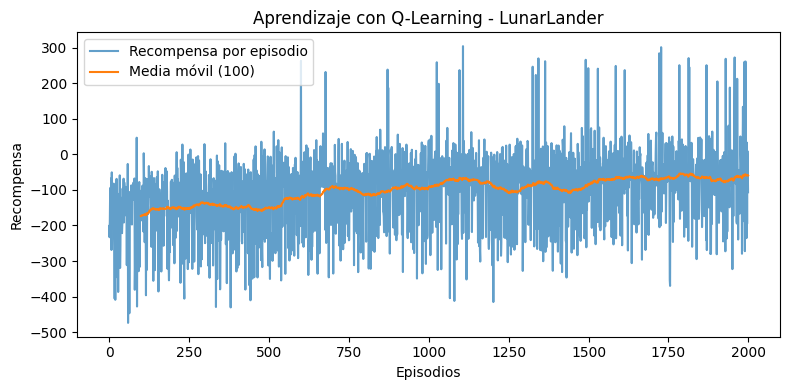

In [7]:
plt.figure(figsize=(8, 4))
plt.plot(acc_reward, label="Recompensa por episodio", alpha=0.7)

if len(acc_reward) > window:
    mv = np.convolve(acc_reward, np.ones(window)/window, mode='valid')
    plt.plot(range(window-1, window-1+len(mv)), mv, label=f"Media móvil ({window})")

plt.xlabel("Episodios")
plt.ylabel("Recompensa")
plt.title("Aprendizaje con Q-Learning - LunarLander")
plt.legend()
plt.tight_layout()
plt.show()

# Recompensas personalizadas

Aunque el entorno Frozen Lake tiene un parámetro para indicar recompensas cuando se producen ciertos estados (alcanzar la meta, caerse en un agujero, o llegar a un bloque de hielo), es posible que queramos definir otras recompensas dado un cierto estado. Por ejemplo, penalizar una acción que no produce un cambio de estado (en este caso seria intentar salirse del mapa). Para ello es necesario implementar nuestro propio "wrapper" de recompensas. Aunque para el caso que hemos planteado, en lugar de realizar un wrapper sobre la recompensa, es posible aplicarlo de la misma manera sobre el método step.

La última versión de Gymnasium te permite hacerlo. Aquí puedes consultar la información: [Documentación RewardWrapper](https://gymnasium.farama.org/tutorials/gymnasium_basics/implementing_custom_wrappers/#inheriting-from-gymnasium-rewardwrapper)

In [ ]:
import gymnasium as gym
from gymnasium import Wrapper

class FrozenLakePenaltyWrapper(Wrapper):
    def __init__(self, env):

    #Para este caso, debes de wrappear el metodo step
    def step(self, action):
        #Falta código
        return obs, reward, terminated, truncated, info

In [ ]:
# Crea el entorno FrozenLake indicandole los parámetros. Para empezar, que el parámetro is_slippery = False.
env = gym.make("FrozenLake-v1", is_slippery=False, map_name="4x4", reward_schedule=(10,0,0), render_mode="human")

# Aplicar el wrapper
env = #Falta código


##Define el número de episodios y comprueba que el wrapper funciona ;) 


# Acciones personalizadas

Similarmente a la personalización de las recompensas, podemos personalizar las acciones que se realizan en el entorno. FrozenLake tiene el modo "is_slippery" que básicamente lo simula repite una acción con una probabilidad dado un estado (si es bloque de hielo).

Sin embargo, otra de las funcionalidades útiles que tiene, es que permite discretizar un conjunto de acciones continuo. Consulta la documentación e prueba el ejemplo que aparece en la documentación para entenderlo. Aquí puedes consultar la información: [Documentación ActionWrapper](https://gymnasium.farama.org/tutorials/gymnasium_basics/implementing_custom_wrappers/#inheriting-from-gymnasium-actionwrapper)
